<a href="https://colab.research.google.com/github/codedec/Project-CustomerChurn-1/blob/main/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import warnings
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [16]:
# ==== Load Raw Dataset ====
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name="E Comm")

In [17]:
# ==== Drop identifier column ====
df = df.drop(columns=["CustomerID"])

In [18]:
# ==== Replace inconsistent values ====
df["PreferredLoginDevice"] = df["PreferredLoginDevice"].replace("Phone", "Mobile Phone")
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].replace("CC", "Credit Card")
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].replace("COD", "Cash on Delivery")
df["PreferedOrderCat"] = df["PreferedOrderCat"].replace("Mobile", "Mobile Phone")

In [19]:
# === Separate numerical and categorical columns ====
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("Churn")
cat_cols = df.select_dtypes(include="object").columns

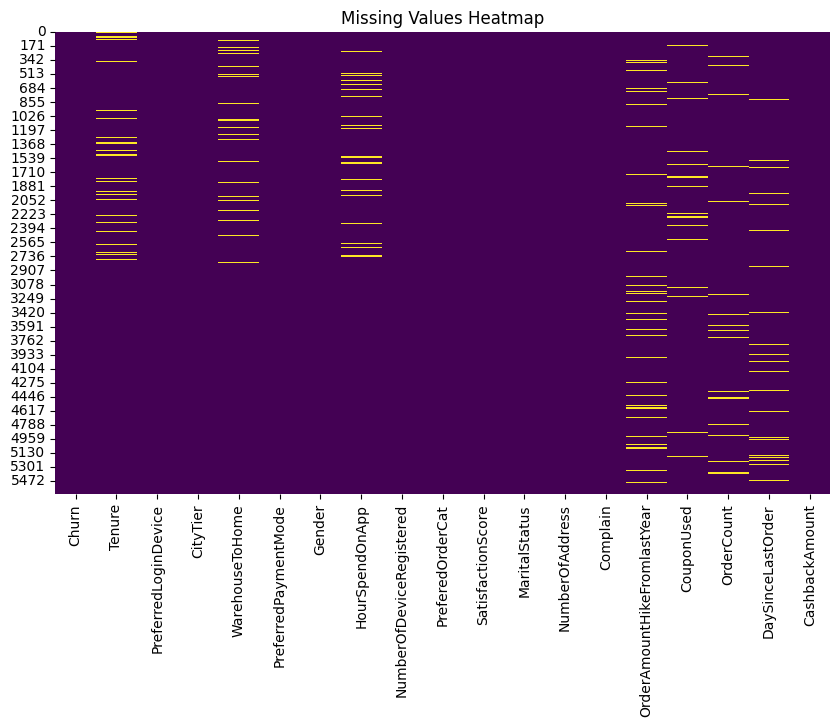

In [20]:
# === Missing Values Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


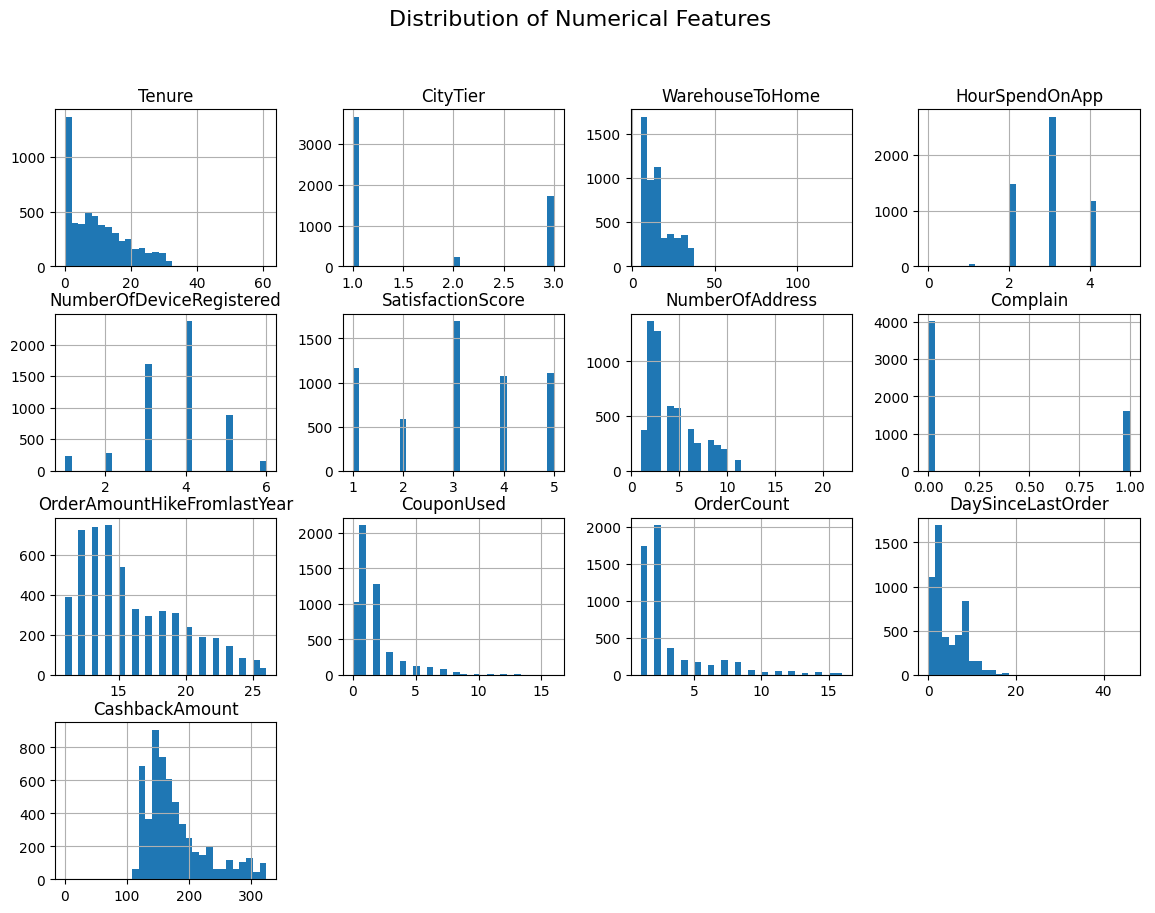

In [21]:
# === Distribution of Numerical Features ===
df[num_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()


In [22]:
# ==== Impute missing numerical values ====
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Correlation Method for Numerical variables: Point-Biserial correlation

In [24]:
# Calculate Point-Biserial correlation
correlations = {}
for col in num_cols:
    if df[col].notna().sum() > 0:
        valid_data = df[['Churn', col]].dropna()
        corr, _ = pointbiserialr(valid_data['Churn'], valid_data[col])
        correlations[col] = corr

In [25]:
# Convert to DataFrame for heatmap
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).sort_values(by='Correlation', ascending=False)


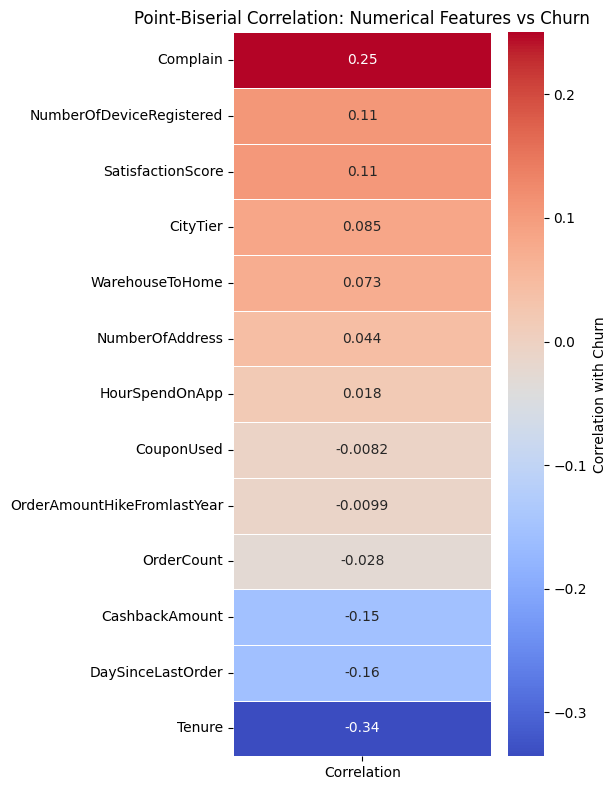

In [26]:
# Plot heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': "Correlation with Churn"})
plt.title("Point-Biserial Correlation: Numerical Features vs Churn")
plt.tight_layout()
plt.show()

# **Insights:**
Tenure has the strongest (negative) correlation with churn → lower tenure → higher churn.

Complain shows a positive correlation → more complaints → higher churn.

DaySinceLastOrder and CashbackAmount also show moderate negative correlation.

# Correlation Method for Categorical variables: Cramér's V

In [27]:
from scipy.stats import chi2_contingency
import numpy as np

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Calculate Cramér’s V for each categorical feature with churn
cramers_results = {}
for col in cat_cols:
    if df[col].notna().sum() > 0:
        v = cramers_v(df[col], df['Churn'])
        cramers_results[col] = v

In [28]:
# Convert to DataFrame
cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=['CramersV']).sort_values(by='CramersV', ascending=False)


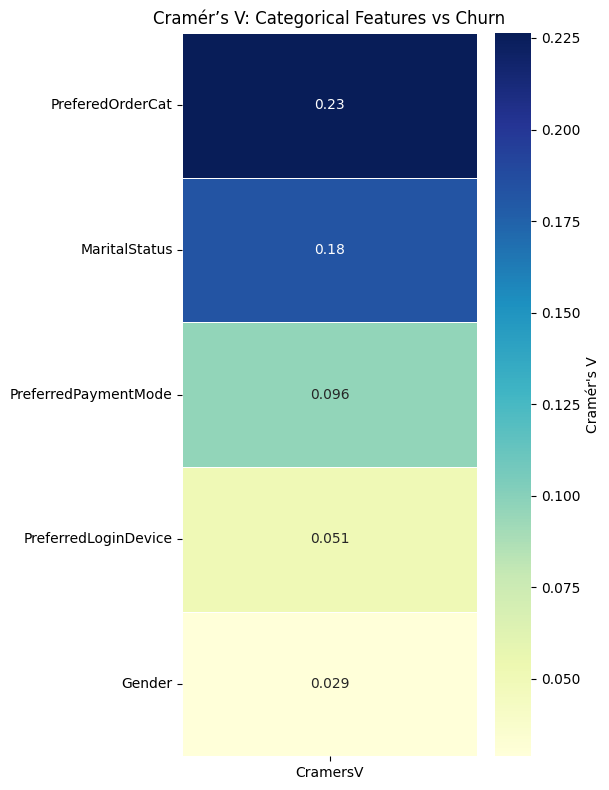

In [29]:
# Plot heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(cramers_df, annot=True, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': "Cramér's V"})
plt.title("Cramér’s V: Categorical Features vs Churn")
plt.tight_layout()
plt.show()

In [31]:
# Calculate churn rate for each category in PreferredOrderCat
churn_by_category = df.groupby('PreferedOrderCat')['Churn'].mean().sort_values(ascending=False)

print(churn_by_category)


PreferedOrderCat
Mobile Phone          0.274038
Fashion               0.154964
Laptop & Accessory    0.102439
Others                0.075758
Grocery               0.048780
Name: Churn, dtype: float64


In [9]:
# ==== Save cleaned data before encoding ====
os.makedirs("data/cleaned", exist_ok=True)
df.to_excel("data/cleaned/E_Commerce_Cleaned_Before_Encoding.xlsx", index=False)
print("Cleaned dataset (before encoding) saved successfully.")

Cleaned dataset (before encoding) saved successfully.


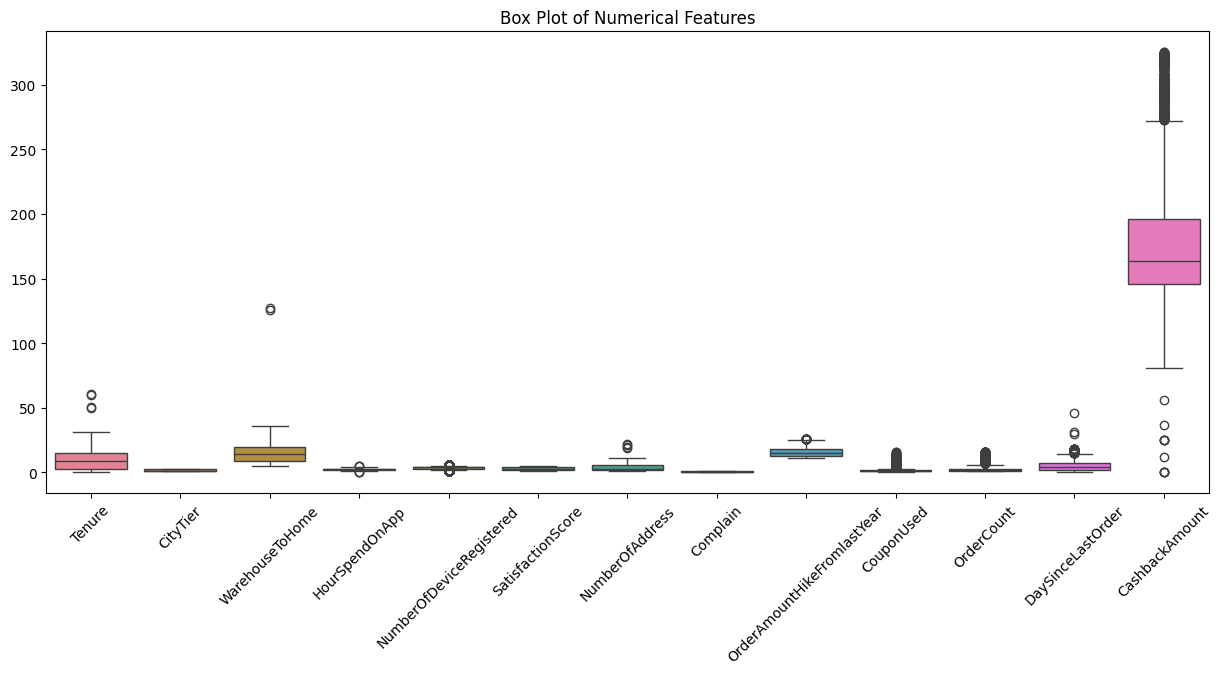

In [10]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title("Box Plot of Numerical Features")
plt.show()


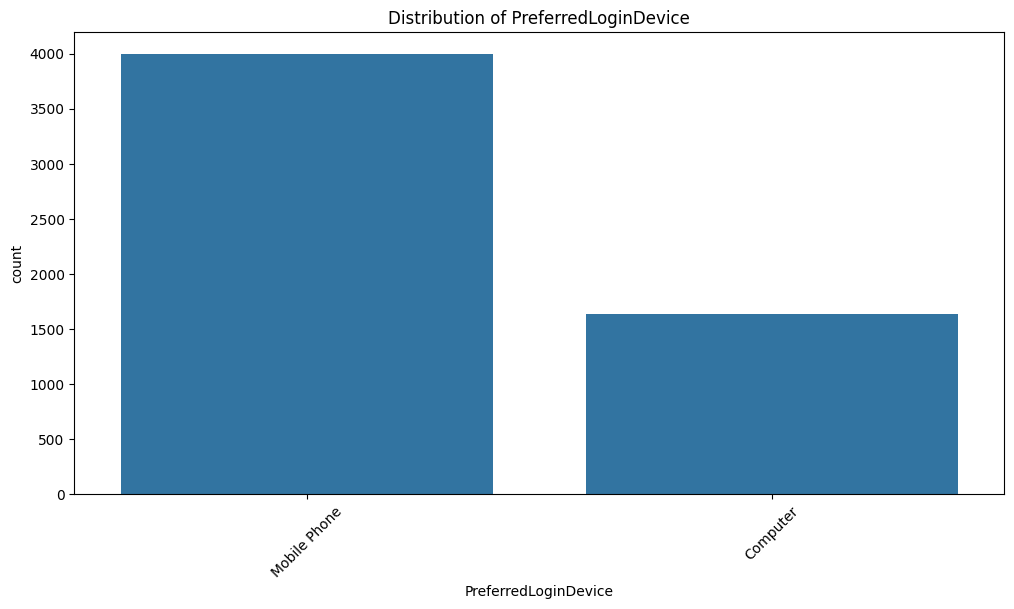

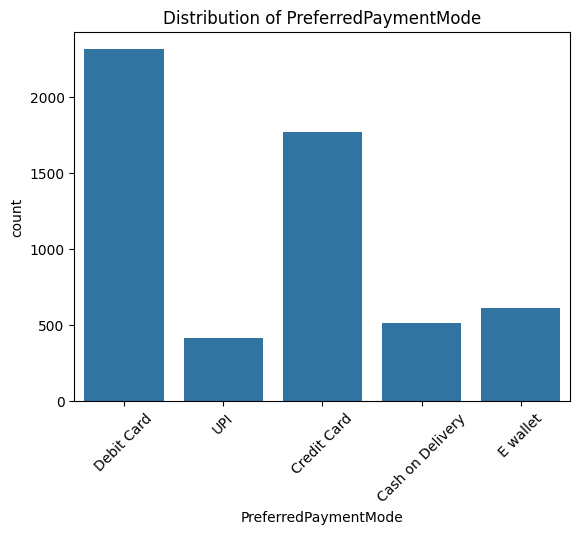

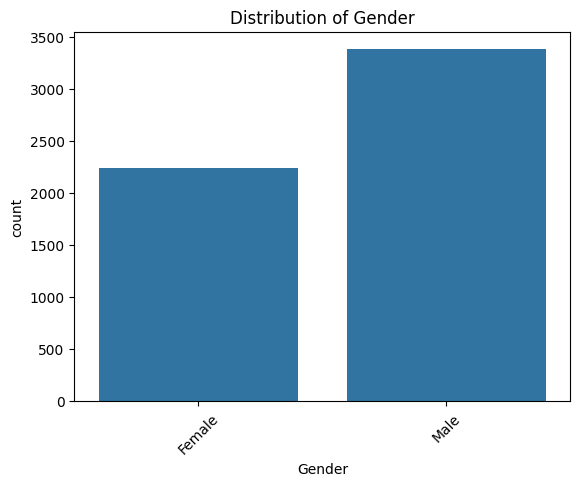

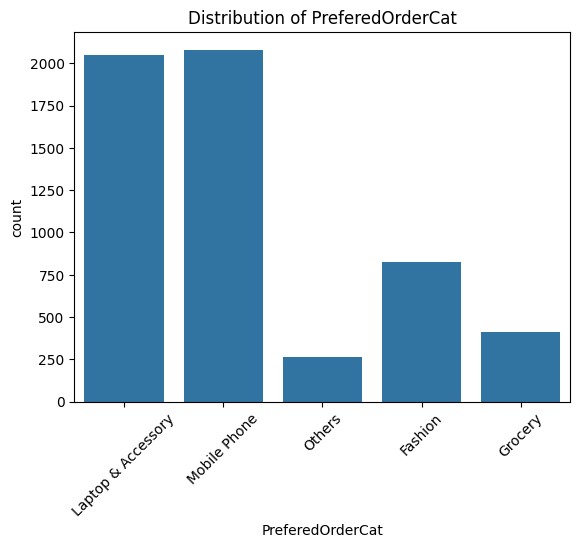

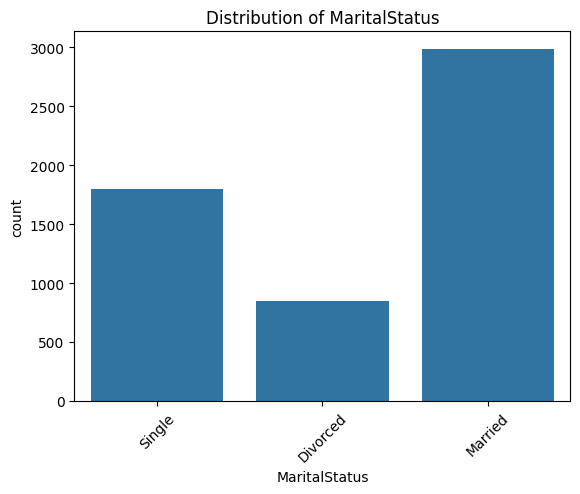

In [11]:
plt.figure(figsize=(12, 6))
for col in cat_cols:
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


KeyError: "None of [Index(['churn'], dtype='object')] are in the [columns]"

In [ ]:
# ==== Encode categorical features using LabelEncoder ====
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# ==== Separate Features and Target ====
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [ ]:
print(f"Missing values in X before SMOTE: {X.isna().sum().sum()}")

Missing values in X before SMOTE: 0


In [ ]:
#      Handle Imbalanced Data
# ================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
#    Feature Selection using Random Forest
# =========================================
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Use median importance as threshold
selector = SelectFromModel(base_rf, threshold="median", prefit=True)
X_selected_all = selector.transform(X_resampled)
selected_all_features = X.columns[selector.get_support()].tolist()

In [ ]:
# === FIX: Do NOT drop any columns after feature selection ===
selected_features = selected_all_features
X_final = X_resampled[selected_features]

print(f"Selected features: {selected_features}")

Selected features: ['Tenure', 'CityTier', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']


In [ ]:
#       Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_resampled, test_size=0.2, random_state=42
)

In [ ]:
#     Random Forest Hyperparams (with stronger regularization)
# ================================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8, 10],  # Lower max_depth to prevent deep trees
    "min_samples_split": [5, 10, 20],  # Increase min_samples_split
    "min_samples_leaf": [4, 8, 12],    # Increase min_samples_leaf
    "max_features": ["sqrt", "log2"],  # Limit number of features per split
    "class_weight": ["balanced"],
}

In [ ]:
#    Hyperparameter Tuning (RSCV)
# ================================
rf = RandomForestClassifier(random_state=42, bootstrap=True)
random_search = RandomizedSearchCV(
    rf, param_grid, cv=5, scoring="roc_auc", n_iter=10, verbose=2, n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [6, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [4, 8, 12],
                                        'min_samples_split': [5, 10, 20],
                                        'n_estimators': [100, 200]},
                   scoring='roc_auc', verbose=2)

In [ ]:
#     Train Best Random Forest
# ================================
best_rf = RandomForestClassifier(
    **random_search.best_params_,
    max_samples=0.8,
    random_state=42,
    bootstrap=True
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_samples=0.8,
                       min_samples_leaf=8, min_samples_split=5,
                       random_state=42)

In [ ]:
#        Model Evaluation
# ================================
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.9449
Test Accuracy: 0.9194


In [ ]:
# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # More robust CV
cv_scores = cross_val_score(
    best_rf,
    X_final[selected_features],
    y_resampled,
    cv=cv,
    scoring="accuracy"
)
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV Accuracy: 0.9326 ± 0.0076


In [ ]:
# ---- Additional Metrics for Imbalanced Data ----
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[865  74]
 [ 77 857]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       939
           1       0.92      0.92      0.92       934

    accuracy                           0.92      1873
   macro avg       0.92      0.92      0.92      1873
weighted avg       0.92      0.92      0.92      1873

ROC-AUC Score: 0.9785


In [ ]:
# ==== Ensure model_reports directory exists ====
os.makedirs("model_reports", exist_ok=True)


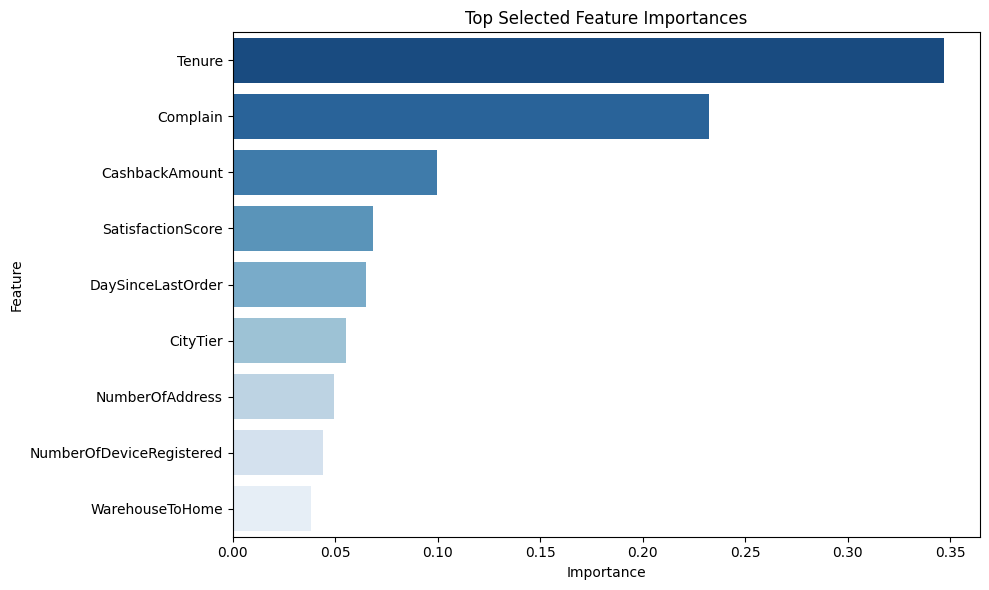

In [ ]:
# ==== Plot and Save Feature Importances ====
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="Blues_r")
plt.title("Top Selected Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

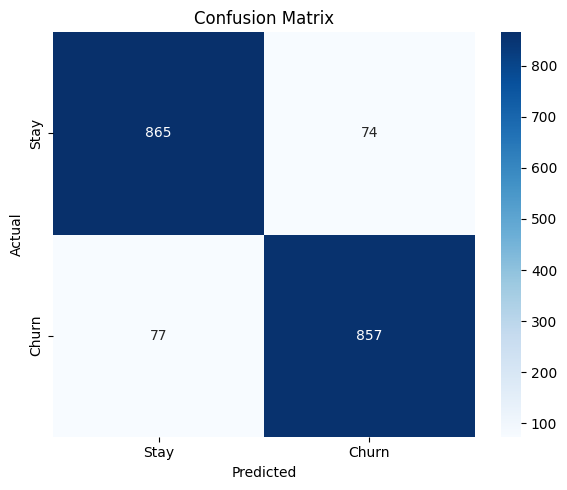

In [ ]:
# ==== Plot and Save Confusion Matrix ====
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stay", "Churn"], yticklabels=["Stay", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

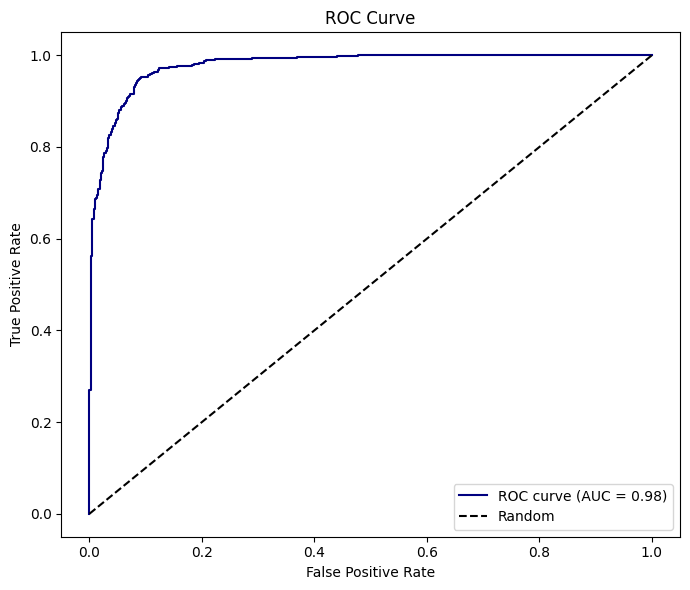

In [ ]:
# ==== Plot and Save ROC Curve ====
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="navy")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
#        Save Model Bundle
# ================================
model_bundle = {
    "model": best_rf,
    "features": selected_features,
    "label_encoders": label_encoders,
    "num_imputer": num_imputer,
}

joblib.dump(model_bundle, "churn_model_bundle.pkl")
print("Model saved as 'churn_model_bundle.pkl'")

Model saved as 'churn_model_bundle.pkl'
